In [5]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import matplotlib
from PIL import Image
import pyximport
pyximport.install(language_level=3)
from semantic_analysis.knowledge_base import filter_kb_histograms, get_sup_ent_lists
from config import VG_kb_pairwise_json_path

with open(VG_kb_pairwise_json_path, 'r') as f:
    json_data = json.load(f)

def transform_kb(t, kb):
    transformed_kb = {pair : transform_hist(t, h) for pair, h in kb}
    return transformed_kb

def clean_histogram(h, top_n=None):
    h_clean = {}
    nclasses = len(h)-2
    elements = [(c,freq) for c,freq in h.items() if c!="entropy" and c!="sup"]
    elements = sorted(elements, key=lambda el: -el[1])
    if top_n:
        elements = elements[:top_n]
    for c,freq in elements:
        if freq>1/nclasses or top_n is not None:
            h_clean[c]=round(freq,3)
    h_clean['sup']=h['sup']
    h_clean['entropy']=round(h['entropy'],2)
    return h_clean

def convert_pair(pair):
    el = pair.split(",")
    return el[0], el[1]

sup, ent = get_sup_ent_lists(json_data)

Outliers: sup>56, logsup>1.7474250108400473
Num outliers = 86
Median(sup): 2


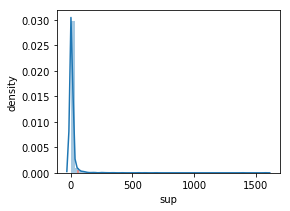

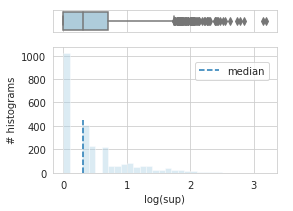

In [6]:
logsup = np.log10(sup)
fig, ax1 = plt.subplots(figsize=[4,3])
sns.distplot(sup, ax=ax1)
ax1.set_xlabel("sup")
ax1.set_ylabel("density")
sns.set_style("whitegrid")

fig, ax2 = plt.subplots(2,1, figsize=[4,3], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(logsup, ax=ax2[0], color="#a6cee3")
sns.distplot(logsup, ax=ax2[1], kde=False, norm_hist=False, color="#a6cee3")
ax2[1].set_xlabel("log(sup)")
ax2[1].set_ylabel("# histograms")


## Find Q1, Q3 and outliers
q1, med, q3 = np.quantile(logsup, [0.25, 0.5, 0.75])
iqr = q3-q1
low = q1-1.5*iqr
high = q3+1.5*iqr
ax1.vlines([int(10**high)],0,0.0006, color='#fb8072', linestyle='--', label="outliers")
ax2[1].vlines([med],0,450, color='#1f78b4', linestyle='--', label="median")
fig.legend(bbox_to_anchor=(0.95,0.65), loc="center right")

print(f"Outliers: sup>{int(round(10**high))}, logsup>{high}")
print(f"Num outliers = {(logsup>high).sum()}")
print(f"Median(sup): {int(round(10**med))}")

In [7]:
outliers = [(pair,h) for pair, h in json_data.items() if h['sup']>=int(10**high)]
outliers_clean = []
for pair, h in outliers:
    outliers_clean.append((pair, clean_histogram(h)))
outliers_clean

[('car,street', {'entropy': 1.51, 'on': 0.762, 'sup': 189}),
 ('person,jacket', {'entropy': 1.09, 'has': 0.149, 'sup': 551, 'wear': 0.775}),
 ('person,pants', {'entropy': 1.2, 'has': 0.205, 'sup': 692, 'wear': 0.717}),
 ('person,bench', {'entropy': 2.25, 'on': 0.471, 'sit on': 0.308, 'sup': 104}),
 ('person,shoes', {'entropy': 1.09, 'has': 0.188, 'sup': 352, 'wear': 0.756}),
 ('tree,sky', {'below': 0.212, 'entropy': 1.85, 'sup': 66, 'under': 0.561}),
 ('building,sky',
  {'below': 0.196, 'entropy': 1.85, 'sup': 153, 'under': 0.575}),
 ('building,street',
  {'behind': 0.131,
   'beside': 0.098,
   'by': 0.115,
   'entropy': 3.18,
   'near': 0.082,
   'next to': 0.279,
   'on': 0.115,
   'sup': 61}),
 ('car,road', {'entropy': 0.79, 'on': 0.875, 'sup': 80}),
 ('sky,car', {'above': 0.878, 'entropy': 0.53, 'sup': 74}),
 ('sky,building', {'above': 0.731, 'entropy': 1.19, 'sup': 245}),
 ('person,shirt', {'entropy': 1.15, 'has': 0.192, 'sup': 1395, 'wear': 0.743}),
 ('person,person',
  {'behind

Reference entropy values. Entr@2=0.69; entr@3=1.1
Num histograms, with ent < entr@3 = 1829


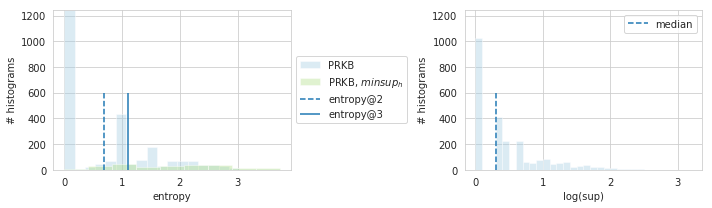

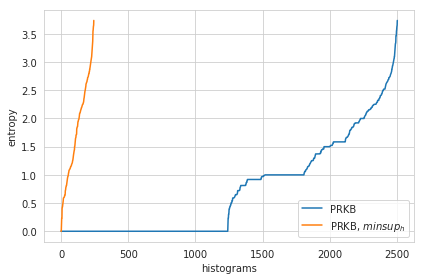

In [13]:
# Filter kb by support
minsup = 20#int(round(10**med))
filtered_kb_minsup = filter_kb_histograms(json_data, minsup, 1000)
_, ent_filtered_kb_minsup = get_sup_ent_lists(filtered_kb_minsup)

# Reference entropy values
entr2 = entropy([0.5,0.5])
entr3 = entropy([1/3,1/3,1/3])
entr4 = entropy([1/4,1/4,1/4,1/4])

print(f"Reference entropy values. Entr@2={round(entr2,2)}; entr@3={round(entr3,2)}")
print(f"Num histograms, with ent < entr@3 = {(ent<entr3).sum()}")

# Distribution
fig, ax = plt.subplots(1,2, figsize=[10,3], sharey=True)#7,3
sns.distplot(ent, ax=ax[0], norm_hist=False, kde=False, label="PRKB", color="#a6cee3");
sns.distplot(ent_filtered_kb_minsup, ax=ax[0], norm_hist=False, kde=False, label="PRKB, $minsup_h$", color="#b2df8a")
ax[0].set_xlabel("entropy")
ax[0].set_ylabel("# histograms")
ax[0].vlines([entr2],0,600, color='#1f78b4', linestyle='--', label="entropy@2")
ax[0].vlines([entr3],0,600, color='#1f78b4', linestyle='-', label="entropy@3")
ax[0].margins(y=0.0)
l = ax[0].legend(bbox_to_anchor=(1.0,0.5), loc="center left")
ax[1].yaxis.set_tick_params(which='both', labelbottom=True)
sns.distplot(logsup, ax=ax[1], kde=False, norm_hist=False, color="#a6cee3")
ax[1].set_xlabel("log(sup)")
ax[1].set_ylabel("# histograms")
ax[1].vlines([med],0,600, color='#1f78b4', linestyle='--', label="median")
ax[1].legend()
ax[1].margins(y=0.0)
plt.tight_layout()
from matplotlib.transforms import Bbox
plt.savefig("./PRKB_entr.eps",bbox_inches=Bbox([[0,0],[5.8,3]]))
plt.savefig("./PRKB_sup.eps",bbox_inches=Bbox([[5.8,0],[10,3]]))

#Simple plot
fig, ax = plt.subplots()
ax.plot(np.arange(len(ent)), np.sort(ent), label="PRKB");
ax.plot(np.arange(len(ent_filtered_kb_minsup)), np.sort(ent_filtered_kb_minsup), label="PRKB, $minsup_h$")
ax.set_xlabel("histograms")
ax.set_ylabel("entropy")
plt.tight_layout()
l = ax.legend(bbox_to_anchor=(1,0), loc="lower right")




Number of selected histograms: 65


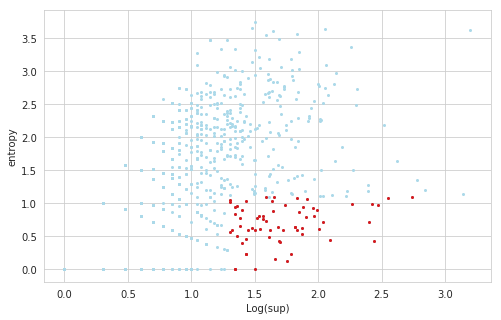

In [14]:
# Filter histograms
filtered_kb = filter_kb_histograms(json_data, minsup, entr3)
sup_filtered, ent_filtered = get_sup_ent_lists(filtered_kb)
print(f"Number of selected histograms: {len(filtered_kb)}")

# Plot scatterplot
plt.figure(figsize=(8, 5))
plt.plot(np.log10(sup), ent, c='#abd9e9', linestyle='', marker='o', markersize=2)
plt.xlabel("Log(sup)")
plt.ylabel("entropy")
plt.grid()
plt.plot(np.log10(sup_filtered), ent_filtered, c='#d7191c', linestyle='', marker='o', markersize=2)
plt.grid()

In [15]:
filtered_kb

{'bench,street': {'above': 0.125,
  'entropy': 0.785235442391543,
  'near': 0.041666666666666664,
  'on': 0.8333333333333334,
  'sup': 24},
 'bike,wheel': {'above': 0.021739130434782608,
  'entropy': 0.15109697051711368,
  'has': 0.9782608695652174,
  'sup': 46},
 'bottle,table': {'above': 0.014705882352941176,
  'entropy': 0.5998132641328944,
  'near': 0.014705882352941176,
  'on': 0.9117647058823529,
  'on the top of': 0.029411764705882353,
  'over': 0.029411764705882353,
  'sup': 68},
 'bowl,table': {'above': 0.02857142857142857,
  'entropy': 0.6054266419690637,
  'on': 0.8857142857142857,
  'on the top of': 0.08571428571428572,
  'sup': 35},
 'building,roof': {'above': 0.015151515151515152,
  'behind': 0.015151515151515152,
  'below': 0.015151515151515152,
  'entropy': 0.6441905475931335,
  'has': 0.9090909090909091,
  'next to': 0.015151515151515152,
  'sup': 66,
  'under': 0.030303030303030304},
 'bus,wheel': {'above': 0.02,
  'entropy': 0.4225426691977457,
  'has': 0.94,
  'on t